### Application of GPcounts with Negative Binomial likelihood on spatial data from Mouse olfactory bulb to identify spatially expressed genes. 

In the following example, we use Mouse olfactory bulb spatially dependent data-set, published by <a href="https://science.sciencemag.org/content/353/6294/78" target="_blank">Stahl et al.</a>. 
To correct for the library size of the spatial samples, we normalise our data by multiplying the mean by a location specific scale factor. To calculate the scale factors we perform negative binomial regression with identity link function using the glm function with negative binomial and identity link function as implemented below. 


In [6]:
import pandas as pd 
import numpy as np 
import gpflow
import tensorflow as tf
from GPcounts import NegativeBinomialLikelihood
from GPcounts.GPcounts_Module import Fit_GPcounts
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

We load the expression matrix and extract the spatial locations 'x' and 'y'

In [7]:
# spatial expression counts matrix
Y = pd.read_csv('../data/MouseOB/Rep11_MOB_0.csv', index_col=[0])
Y = Y.T[Y.sum(0) >= 3].T # Filter out genes with less than 3 total counts

In [8]:
spatial_locations = pd.DataFrame(index=Y.index)
spatial_locations['x'] = Y.index.str.split('x').str.get(0).map(float)
spatial_locations['y'] = Y.index.str.split('x').str.get(1).map(float)

In [9]:
spatial_locations['total_counts'] = Y.sum(1)
Y = Y.loc[spatial_locations.index]
X = spatial_locations[['x', 'y']]
# scale = pd.read_csv('../data/MouseOB/scales_nb.txt', sep="\t") # load the file with the scale factors 

Calculate the scale coefficients

In [10]:
import statsmodels.formula.api as smf 
import statsmodels.api as sm
scales = []
for i in range(0,len(Y.columns)):
    model=smf.glm(formula = "Y.iloc[:,i]~0+spatial_locations['total_counts']", data=Y,family=sm.families.NegativeBinomial(sm.families.links.identity())).fit()
    res = model.params[0]*spatial_locations['total_counts']
    scales.append(res)
scalesdf=pd.DataFrame(scales)
scalesdf=scalesdf.T
print(scalesdf)

               total_counts  total_counts  total_counts  total_counts  \
16.92x9.015        0.358224      0.378969      1.334467      0.971175   
16.945x11.075      0.705199      0.746039      2.627032      1.911856   
16.97x10.118       0.237754      0.251523      0.885691      0.644573   
16.939x12.132      0.432823      0.457889      1.612368      1.173421   
16.949x13.055      0.355383      0.375964      1.323885      0.963474   
...                     ...           ...           ...           ...   
23.124x24.046      0.548393      0.580152      2.042892      1.486740   
21.01x23.944       0.488358      0.516640      1.819250      1.323982   
22.053x23.962      0.520921      0.551089      1.940552      1.412261   
27.018x20.088      0.320781      0.339358      1.194983      0.869664   
17.964x10.137      0.585759      0.619682      2.182091      1.588044   

               total_counts  total_counts  total_counts  total_counts  \
16.92x9.015        0.874044      3.135066      0.6

After filtering, the whole data-set contains 14,859 genes but for simplicity we run this example on the first 20 genes. This will take a few minutes. For the purposes of comparison, we provide a file (../data/MouseOB/SE_genes_comparison.csv) with the all spatially expressed genes found by running GPcounts on the whole data-set as well as the spatially expressed genes identified by [SpatialDE](https://github.com/Teichlab/SpatialDE/tree/cb5deb8c24e7c98c77672784b43cef41b2f24d99) package.    

In [11]:
Y = Y.T
Y_run = Y.iloc[0:20,:] # select first 20 genes to run GPcounts
X = X[['x', 'y']]

To run the scaled version of the GPcounts, where the negative binomial mean is multiplied by the pre-calculated scale factors (scalesdf), we should use the three optional arguments in the function Fit_GPcounts:  'scale=scalesdf' and 'nb_scaled'.
The 'scale' argument contains the file with the scale factors, the 'nb_scaled=True' argument is used to  activate the scaled (multiplicative) version.  

In [12]:
gene_name = []
nb_scaled = True # set the nb_scaled argument to True to pass the scale factors 
gene_name = Y_run.index
likelihood = 'Negative_binomial' 
gp_counts = Fit_GPcounts(X,Y_run.loc[gene_name], scale = scalesdf, nb_scaled=nb_scaled,safe_mode=False)

We run the One_sample_test with negative binomial likelihood for the 20 genes. Then we run gp_counts.calculate_FDR and the 'results' will show the following:

* Name of the gene
* Dynamic_model_log_likelihood - Likelihood of the dynamic model  
* Constant_model_log_likelihood - Likelihood of the constant ('null') model
* log_likelihood_ratio - Ratio between the dynamic and constant models
* p value - statistical significance based on P value 
* q value - Statistical significance based on the "adjusted p value" for the false discovery rate or q value 

In [13]:
log_likelihood_ratio = gp_counts.One_sample_test(likelihood)
log_likelihood_ratio

100%|██████████| 20/20 [00:36<00:00,  1.85s/it]


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
Nrf1,-249.249995,-249.253298,0.003303
Zbtb5,-264.375801,-264.404124,0.028322
Ccnl1,-470.155381,-470.182132,0.026751
Lrrfip1,-425.484372,-426.374139,0.889766
Bbs1,-399.719524,-399.765082,0.045557
Lix1,-613.495949,-615.966547,2.470598
Whrn,-343.357926,-344.281664,0.923738
Ate1,-504.470200,-506.274552,1.804351
Ubac1,-519.843176,-519.901397,0.058221
Rab34,-404.388548,-404.388546,-0.000002


In [15]:
results = gp_counts.calculate_FDR(log_likelihood_ratio)
results

,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,p_value,q_value
Nrf1,-249.249995,-249.253298,0.003303,9.352206e-01,1.000000e+00
Zbtb5,-264.375801,-264.404124,0.028322,8.118797e-01,1.000000e+00
Ccnl1,-470.155381,-470.182132,0.026751,8.170769e-01,1.000000e+00
Lrrfip1,-425.484372,-426.374139,0.889766,1.822067e-01,3.644134e-01
Bbs1,-399.719524,-399.765082,0.045557,7.627650e-01,1.000000e+00
Lix1,-613.495949,-615.966547,2.470598,2.622387e-02,1.048955e-01
Whrn,-343.357926,-344.281664,0.923738,1.740772e-01,3.644134e-01
Ate1,-504.470200,-506.274552,1.804351,5.747793e-02,1.850650e-01
Ubac1,-519.843176,-519.901397,0.058221,7.329253e-01,1.000000e+00
Rab34,-404.388548,-404.388546,-0.000002,1.000000e+00,1.000000e+00


Plot some spatially expressed genes from the data-set based on the q values provided in file 'SE_genes_comparison.csv'

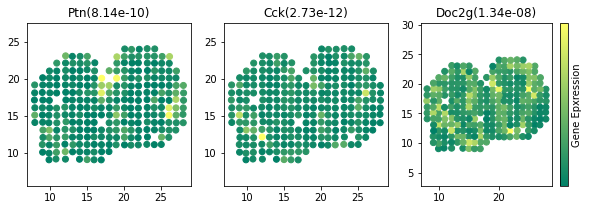

In [9]:
from matplotlib import rcParams
plt.rcParams["figure.figsize"] = [10,3]
m = ['Ptn(8.14e-10)', 'Cck(2.73e-12)', 'Doc2g(1.34e-08)']
for i, g in enumerate(['Ptn', 'Cck', 'Doc2g']):
    plt.subplot(1, 3, i + 1)
    plt.scatter(spatial_locations['x'], spatial_locations['y'], c=Y.T[g],cmap = 'summer')
    # plt.figure(figsize=(10,3))
    plt.title(m[i])
    plt.axis('equal')
plt.colorbar(ticks=[0,1],label = 'Gene Epxression')

plt.show()


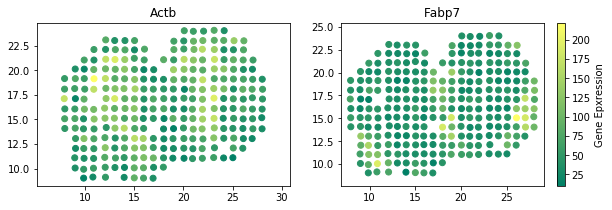

In [12]:
from matplotlib import rcParams
plt.rcParams["figure.figsize"] = [10,3]
m = ['Actb', 'Fabp7']
for i, g in enumerate(['Actb', 'Fabp7']):
    plt.subplot(1, 2, i + 1)
    plt.scatter(spatial_locations['x'], spatial_locations['y'], c=Y.T[g],cmap = 'summer')
    # plt.figure(figsize=(10,3))
    plt.title(m[i])
    plt.axis('equal')
plt.colorbar(label = 'Gene Epxression')

# plt.show()
plt.savefig('svgenes_1.pdf')

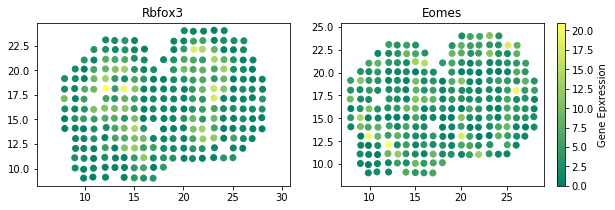

In [11]:
 from matplotlib import rcParams
plt.rcParams["figure.figsize"] = [10,3]
m = ['Rbfox3', 'Eomes']
for i, g in enumerate(['Rbfox3', 'Eomes']):
    plt.subplot(1, 2, i + 1)
    plt.scatter(spatial_locations['x'], spatial_locations['y'], c=Y.T[g],cmap = 'summer')
    # plt.figure(figsize=(10,3))
    plt.title(m[i])
    plt.axis('equal')
plt.colorbar(label = 'Gene Epxression')
plt.savefig('svgenes_2.pdf')
# plt.show()

 We plot two genes with very low expression which have been identified as spatially expressed by SpatialDE but not by GPcounts 

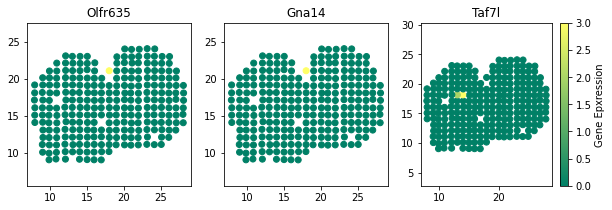

In [10]:
plt.rcParams["figure.figsize"] = [10,3]
n = ['Olfr635','Gna14', 'Taf7l']
for i, g in enumerate(['Olfr635','Gna14', 'Taf7l']):
    plt.subplot(1, 3, i + 1)
    plt.scatter(spatial_locations['x'], spatial_locations['y'], c=Y.T[g],cmap = 'summer')
    # plt.figure(figsize=(10,3))
    plt.title(n[i])
    plt.axis('equal')
plt.colorbar(label = 'Gene Epxression')